In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import sys

sys.path.append("..")
from utils.modules import AssetLevels, TrendLine
from utils.functions import simulate_gbm, generate_fractal_trend_lines
from utils.trend_line_optimizer import fit_trendlines_high_low


plt.rcParams['figure.figsize'] = [12, 7]

plt.rc('font', size=14) 


## Get the historical data

- Input the symbol to activate the dataloader script, which downloads the csv into data folder
- Saves the csv into historical_data df

In [3]:
symbol = "TSLA"
historical_data = pd.read_csv(f"../data/{symbol}_historical_data.csv")
historical_data['Date'] = pd.to_datetime(historical_data['Date'])

In [4]:
support_coefs, resist_coefs = fit_trendlines_high_low(historical_data['High'],historical_data['Low'],historical_data['Close'])

/var/folders/t5/8fqbwc2d221c1h8pnz5m9nm40000gn/T/ipykernel_22411/1555377202.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


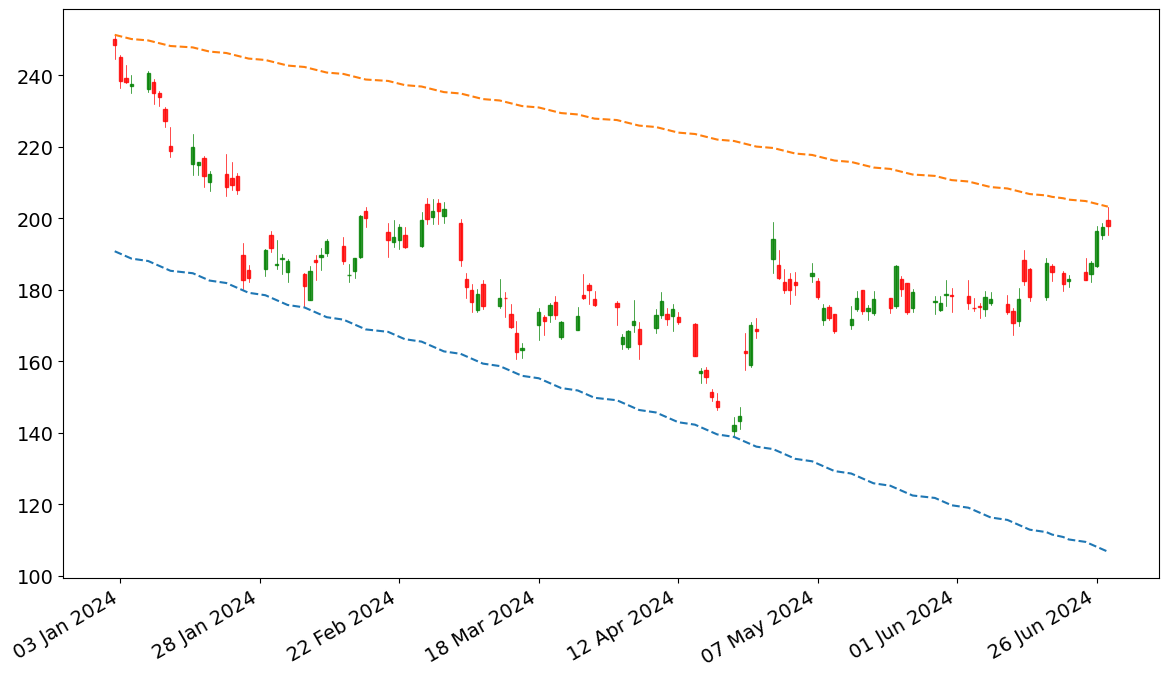

In [5]:
df = historical_data.copy()
df['Date'] = df['Date'].apply(mpl_dates.date2num)

df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]


fig, ax = plt.subplots()

candlestick_ohlc(ax,df.values,width=0.6, \
                colorup='green', colordown='red', alpha=0.8)


support_line = np.arange(len(historical_data)) * support_coefs[0] + support_coefs[1]
resist_line = np.arange(len(historical_data)) * resist_coefs[0] + resist_coefs[1]
plt.plot(df['Date'], support_line, '--')
plt.plot(df['Date'], resist_line, '--')


date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
fig.show()


## Generating trend lines using fractal pattern for support and resistance

/var/folders/t5/8fqbwc2d221c1h8pnz5m9nm40000gn/T/ipykernel_22411/1249799194.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


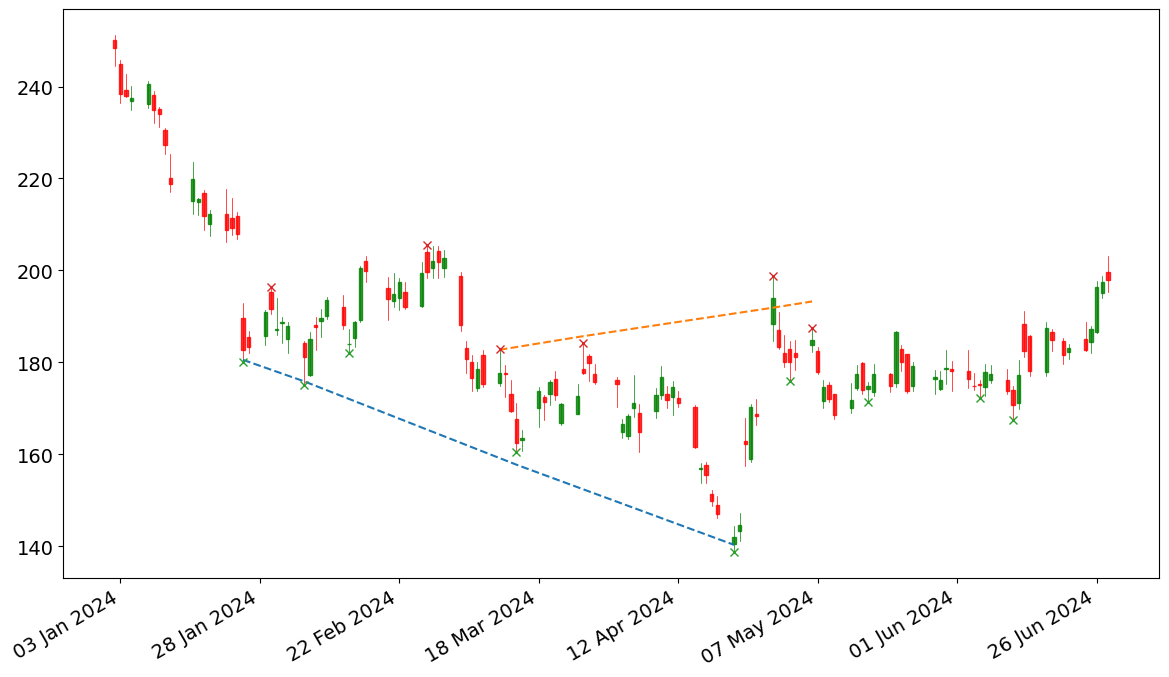

In [6]:
supports, resistances, support_lines, resistance_lines = generate_fractal_trend_lines(historical_data)

df = historical_data.copy()
df['Date'] = df['Date'].apply(mpl_dates.date2num)

df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]


fig, ax = plt.subplots()

candlestick_ohlc(ax,df.values,width=0.6, \
                colorup='green', colordown='red', alpha=0.8)
plt.plot(df['Date'][support_lines[0].x.flatten()], support_lines[0].y_pred, linestyle='--')
plt.plot(df['Date'][resistance_lines[0].x.flatten()], resistance_lines[0].y_pred, linestyle='--')


plt.plot(df['Date'][supports[:,0]], supports[:,1], 'x')
plt.plot(df['Date'][resistances[:,0]], resistances[:,1], 'x')

date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
fig.show()


## Simulating a GBM

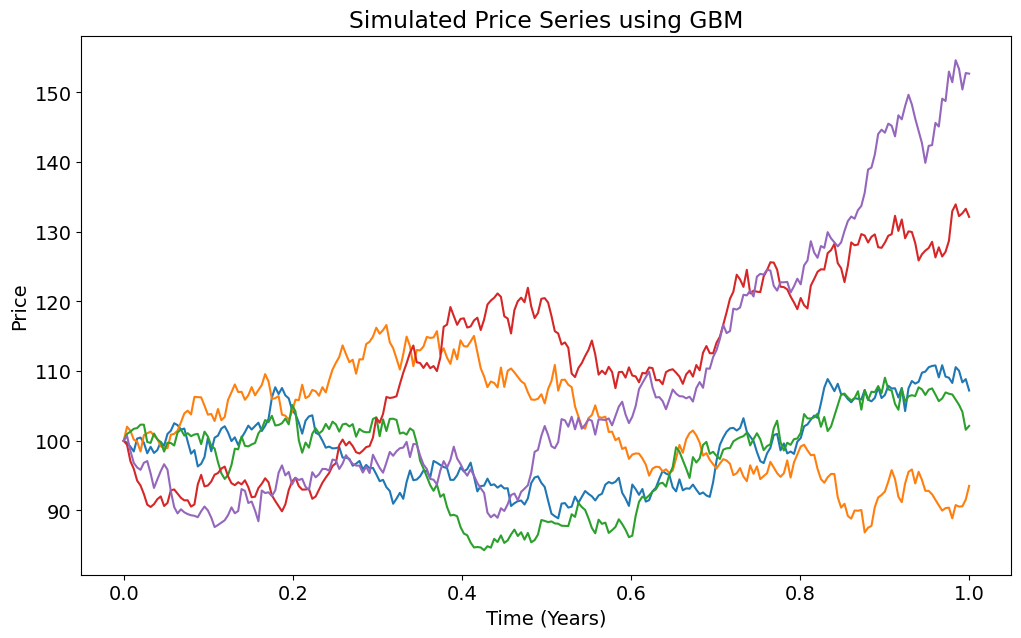

In [15]:
# Example usage:
S0 = 100  # Initial price
mu = 0.05  # Drift
sigma = 0.2  # Volatility

T = 1.0  # 1 year
dt = 1/252  # Daily steps
N = 5  # Number of simulated paths

simulated_data, time = simulate_gbm(S0, mu, sigma, T, dt, N)

# Plot the simulated data
plt.plot(time, simulated_data)
plt.title("Simulated Price Series using GBM")
plt.xlabel("Time (Years)")
plt.ylabel("Price")
plt.show()
